# Introduction

Welcome to the part "XAI" (e**X**plainable **A**rtificial **I**ntelligence) of the lecture "Responsible Machine Learning with Insurance Applications".

The basic question of XAI is:

> How to explain and interpret a given model, even if it seems a black box?

Answering this question is a key aspect of responsible machine learning (ML). It not only provides valuable information and knowledge for stakeholders, but also helps to identify problems in the modeling process.

# Scope and Taxonomy

Thanks to the rise of ML and the desire to explain its models, the field of explainable ML is developing rapidly. We will study the most important methods for *structured data*. Unstructured data (images, audio sequences, text, ...) often has its own specialized explanation tools. Covering them is beyond the scope of this lecture.

The following taxonomy of explainability methods is often helpful, see @molnar2019 for more background:

-   *Global versus local explainability:* Global explainability methods describe the model as a whole, while local methods focus on explaining model behavior around a single observation. We will mainly cover global methods, with one notable exception (SHAP).
-   *Model-specific versus model-agnostic:* Each modeling technique typically has its own tailored methods for interpretation. For example, a linear regression can be explained by examining its coefficients. Tree-based models are another example: The variable importance of a feature in such a model can be assessed, for instance, by studying the average loss reduction from splits on that feature. In contrast to such model-specific methods, a model-agnostic method is suitable for all types of models. Our focus is on model-agnostic techniques, although we sometimes show model-specific methods for comparison.
-   *Intrinsic versus post-hoc*: The simple structure of a linear model, an additive model, or a short decision tree makes such modeling techniques intrinsically interpretable. In contrast, models with complex structure (e.g., a neural net) are interpretable only by post-hoc analysis of the fitted model. Model-agnostic interpretability methods are always used for post-hoc explainability. However, they can also be applied to an intrinsically interpretable model.

Note: We will use the terms "explainable", "interpretable", and "intelligible" interchangeably, although subtle differences are sometimes pointed out in the literature.

# Outline

This chapter introduces important notations, the necessary background on non-life insurance pricing, and the main example that will guide us on our way through the illuminating world of model explainability.

In the chapter "Explaining Models" we will learn the most important methods of post-hoc interpretability. We will also learn how to use the insights gained from interpreting complex models to improve linear models.

The third chapter, "Improving Explainability", takes a different path. Here we explore ways to improve the intrinsic explainability of complex models by simplifying their internal structure, in particular by forcing parts of the model to be additive and/or monotonic.

# Notation

Throughout the XAI notebooks, we consider a typical modeling situation: a distributional property $ T $ of a real-valued response variable $Y$ should be approximated by a model $ m: \boldsymbol x \in \mathbb R^p \mapsto \mathbb R $ of a $ p $-dimensional feature vector $ \boldsymbol X = (X^{(1)}, \dots, X^{(p)}) $ with value $ \boldsymbol x = (x^{(1)}, \dots, x^{(p)}) \in \mathbb R^p $, i.e., $$
  T(Y\mid \boldsymbol X = \boldsymbol x) \approx m(\boldsymbol x).$$ 
For brevity, we write $ T(Y\mid \boldsymbol X = \boldsymbol x) = T(Y\mid \boldsymbol x) $.

Examples of $T$ are the expectation $T =\mathbb E$, or a quantile $q_\alpha$. The model $m$ is then estimated by $\hat m$ from the training data by minimizing some objective criterion typically of the form $$
  \frac{1}{\sum_{i = 1}^n w_i} \sum_{i = 1}^n w_i L(\hat y_i, y_i) + \lambda \Omega(m),$$ where

-   $ L $ is a loss function (sometimes called "scoring function") ideally strictly consistent for $T$, e.g., the squared error $L(z, y) = (y - z)^2$,
-   $1 \le i \le n$ are the observations in the dataset considered,
-   $\lambda \Omega(m)$ is an optional penalty to reduce overfitting,
-   $\boldsymbol w = (w_1, \dots, w_n)^T$ is the vector of (optional) non-negative case weights of the $n$ observations ($w_i = 1$ if there are no such case weights),
-   $\boldsymbol y = (y_1, \dots, y_n)^T$ are the $n$ observed values of $Y$,
-   $\boldsymbol{\hat y} = (\hat y_1, \dots, \hat y_n)^T$ is the vector of predicted or fitted values, i.e., $\hat y_i = \hat m(\boldsymbol x_i)$,
-   $\boldsymbol x_1, \dots, \boldsymbol x_n$ are the feature vectors corresponding to the $n$ observations. Consequently, $x_i^{(j)}$ denotes the value of the $j$-th feature of the $i$-th observation.

Even if many of the concepts covered in this lecture also work for classification settings with more than two classes, we focus on regression and binary classification.

Some additional notation is introduced in the following examples of important model classes.

## Example: Linear regression

The model equation of a linear regression model is assumed to satisfy $$
  \mathbb E(Y \mid \boldsymbol x) = m(\boldsymbol x) = \beta_o + \beta_1 x^{(1)} + \dots + \beta_p x^{(p)},$$ where $(\beta_o, \beta_1, \dots, \beta_p) \in \mathbb R^{p+1}$ is the parameter vector to be estimated by minimizing the sum of squared errors $$
  \sum_{i = 1}^n (y_i - \hat y_i)^2$$ by linear least-squares.

## Example: Generalized linear model (GLM)

The model equation of a generalized linear model [@nelder1972] with link function $g$ and inverse link $g^{-1}$ is assumed to satisfy: $$
  \mathbb E(Y \mid \boldsymbol x) = m(\boldsymbol x) = g^{-1}(\eta(\boldsymbol x)) = g^{-1}(\beta_o + \beta_1 x^{(1)} + \dots + \beta_p x^{(p)}),$$ where the linear part $\eta$ of the model is called the *linear predictor*. The parameters $\beta_j$ are estimated by minimizing the (possibly weighted) average deviance $\bar S$, a measure depending on the distribution assumed for $Y\mid \boldsymbol x$. Typical distributions are the Poisson distribution, the Gamma distribution, the Bernoulli distribution, and the normal distribution.

In this lecture, we will often model insurance claim counts by a Poisson GLM with log link $g$. Its (possibly weighted) average deviance on the training data $D_{\text{train}} = \{(y_i, w_i, \boldsymbol x_i), i = 1, \dots, n\}$ is given by the formula $$
   \bar S(\hat m, D_{\text{train}}) = \sum_{i = 1}^n w_i S(\hat y_i, y_i) / \sum_{i = 1}^n w_i,$$ where $S$ is the (unit) Poisson deviance of a single observation, $$
  S(\hat y_i, y_i) = 2(y_i \log(y_i / \hat y_i) - (y_i - \hat y_i)).$$

## Example: Generalized additive model (GAM)

An important extension of the GLM is the generalized additive model [@hastie1986; @hastie1990; @wood2017]. Its model equation is assumed to satisfy $$
  \mathbb E(Y \mid \boldsymbol x) = m(\boldsymbol x) = g^{-1}(\beta_o + f_1(x^{(1)}) + \dots + f_p(x^{(p)}))$$ for sufficiently nice functions $f_j$ describing the Ceteris Paribus effect of feature $X^{(j)}$ on $g(\mathbb E(Y \mid \boldsymbol x))$, and $\beta_o$ is the intercept. As functions $f_j$, often penalized regression smooths are used that are then being estimated to minimize the distribution specific average deviance. The functions $f_j$ are usually zero-centered to uniquely define them. Some of the components $f_j$ can also be fully parametric, just like in a GLM.

GAMs and GLMs can also contain interaction terms, i.e., components that depend on more than one covariate.

## Example: Gradient boosted decision trees (GBDT)

Like a neural net, gradient boosted trees [@friedman2001] allow to represent extremely flexible model equations. They can automatically pick up complex interactions between covariates, a process that would need to be done in a manual way for linear models. Such models are fitted by applying gradient boosting on the objective function chosen in line with $T$.

In the statistical software R, different implementation of gradient boosting exist. We will mainly work with "XGBoost" [@chen2016] and "LightGBM" [@ke2017]. They allow to model different functionals $T$, and offer a rich set of objective functions and many regularization parameters. We will, as a competitor of the Poisson GLM and the Poisson GAM, also consider Poisson boosted trees.

For details on gradient boosting, check our corresponding lecture slides, and also [this section](https://mayer79.github.io/statistical_computing_material/5_Trees.html#4_Gradient_Boosted_Trees) of "Statistical Computing".

# Non-Life Insurance Pricing

The models described above are highly relevant in insurance pricing. A brief description of this field is given here.

One of the main tasks of a non-life pricing actuary is to predict the *pure premium* associated with an insurance policy. It is defined as the financial loss per year or per some other relevant exposure measure. The insurance company uses this information to optimize its tariffs and to estimate expected future profit. Such predictions are usually made by statistical models based on historical data on policies and claims.

Slightly adapting the notation of @wuethrich2021, we use the following terms to characterize an insurance policy with exposure $w$. Throughout these notebooks, $w$ is measured in yearly units.

-   $w > 0$: The exposure. All other quantities will refer to this.
-   $N$: Number of claims.
-   $C$: Total claim amount.
-   $C / w$: Pure premium.
-   $Y = N / w$: The claims frequency, i.e., the number of claims per exposure.
-   $Z = C / N$: The claims severity, i.e., the average cost per claim (undefined if $N = 0$).
-   $\boldsymbol X$: One or more risk characteristics describing the policy.

Observed values for two fictive motor third-part liability (MTPL) policies could look like this:

| id  | $w$ | $N$ | $C$  | $C/w$ | $Y$ | $Z$  | Driver's age | Horse power |
|:---:|:---:|:---:|:----:|:-----:|:---:|:----:|:------------:|:-----------:|
|  1  |  1  |  0  |  0   |   0   |  0  |  \-  |      28      |     80      |
|  2  | 0.5 |  2  | 5000 | 10000 |  4  | 2500 |      20      |     250     |
|  2  | 0.5 |  1  | 1000 | 2000  |  2  | 1000 |      21      |     250     |

Due to the additivity of $w$, $N$, and $C$, these quantities can also be defined for multiple policies together, e.g., for the entire portfolio.

Instead of directly modeling $\mathbb E(C / w \mid \boldsymbol x)$, pricing actuaries often decompose the pure premium into a product of frequency and severity $$
  C / w = (C / w) \cdot (N / N) = (N / w) \cdot (C / N) = Y  Z$$ and derive two models: One for the claims frequency $$
  \mathbb E(Y \mid \boldsymbol x) \approx m_Y(\boldsymbol x),$$ classically a Poisson GLM with log link and case weights $w$; and another one for the severity $$
  \mathbb E(Z \mid \boldsymbol x) \approx m_Z(\boldsymbol x),$$ classically a Gamma GLM with log link and case weights $N$, using only rows with $N>0$.

Assuming conditional independence of $Y$ and $Z$, the combined model for the pure premium is then given by the product of the two models, i.e., by $$
  \mathbb E(C / w \mid \boldsymbol x) \approx m_Y(\boldsymbol x)  m_Z(\boldsymbol x).$$ The GLMs can be replaced by corresponding GAMs or modern ML techniques like deep learning and boosted trees. These alternatives are ideally fitted using the same loss functions (the corresponding deviance), the same case weights, and also using log links.

For more information on non-life insurance pricing, we recommend the excellent references @wuethrich2021 and @ohlsson2015.

## Further remarks

-   The two models can use different feature sets.
-   The severity model uses a log link to ensure a multiplicative model structure on the response scale. Since the logarithm is not the natural link function of the Gamma GLM, this leads to a slight bias on the scale of the response, which can be eliminated, e.g., by applying an empirical multiplicative correction factor $$
    c = \sum_{i = 1}^n y_i / \sum_{i = 1}^n \hat y_i$$ calculated on the training data.
-   In R, when modeling claim frequencies with GLMs or GAMs, we will use the distribution family `quasipoisson`. This (a) suppresses a warning on non-integer responses and (b) allows for overdispersion. It provides the same parameter estimates as the `poisson` family.
-   Instead of fitting a Poisson model for claims frequency using case weights $w$, one can alternatively model the claim counts $N$ by a Poisson model without case weights but using an offset of $\log(w)$. Such a model will predict expected claim counts rather than expected claim frequencies. Nevertheless, the estimated effects will be identical between the two variants.

# Main Example

We will work with the French motor third-part liability (MTPL) dataset available on [openML (ID 41214)](https://www.openml.org/d/41214) to model claims frequency.

## The data

The first R script of this notebook performs the following steps:

-   The dataset is downloaded from OpenML and saved.
-   Rows with identical risk factors ("Area", "VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region") are assigned to a "group_id". We assume that rows in such a group represent the same policy, even if their "IDpol" varies. This seems to be a curious property of this dataset. As we will see later, working with grouped data is a tricky business, and ignoring grouping can lead to biased results.
-   Certain transformations are applied. For instance, very large feature values are truncated and small categories are collapsed to one category.
-   The column names of the features, of the response and of the exposure are stored in variables.
-   All relevant columns are described univariately.

Note: We will often use the forward pipe operator `|>`. It moves the left-hand side as first argument in the function on the right-hand side. An example: `iris |> head()` is the same as `head(iris)`. If you need a quick refresher on R, go through [the first chapter](https://mayer79.github.io/statistical_computing_material/1_R_in_Action.html) of my statistical computing lecture.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] 678013

IDpol,group_id,ClaimNb,VehPower,VehAge,VehBrand,VehGas,DrivAge,logDensity,PolicyRegion,Exposure,Freq
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
5109583,1,0,4,0,B12,Regular,18,3.871201,Other,0.02,0
107133,2,0,4,0,Other,Diesel,19,3.871201,Other,0.41,0
5107815,3,0,4,0,B12,Regular,19,3.332205,Other,0.03,0
5107816,3,0,4,0,B12,Regular,19,3.332205,Other,0.06,0
107132,4,0,4,0,Other,Diesel,19,3.871201,Other,0.31,0
4063566,5,0,4,0,B12,Diesel,19,2.995732,Other,0.03,0
4063568,5,0,4,0,B12,Diesel,19,2.995732,Other,0.02,0
4063569,5,0,4,0,B12,Diesel,19,2.995732,Other,0.18,0


    VehPower         VehAge        VehBrand          VehGas      
 Min.   : 4.00   Min.   : 0.000   B12  :166024   Diesel :332136  
 1st Qu.: 5.00   1st Qu.: 2.000   B1   :162736   Regular:345877  
 Median : 6.00   Median : 6.000   B2   :159861                   
 Mean   : 6.43   Mean   : 6.976   Other:189392                   
 3rd Qu.: 7.00   3rd Qu.:11.000                                  
 Max.   :12.00   Max.   :20.000                                  
    DrivAge        logDensity     PolicyRegion      Exposure       
 Min.   :18.00   Min.   : 0.000   R24  :160601   Min.   :0.002732  
 1st Qu.:34.00   1st Qu.: 4.522   R11  : 69791   1st Qu.:0.180000  
 Median :44.00   Median : 5.974   R53  : 42122   Median :0.490000  
 Mean   :45.49   Mean   : 5.982   R82  : 84752   Mean   :0.528545  
 3rd Qu.:55.00   3rd Qu.: 7.413   R93  : 79315   3rd Qu.:0.990000  
 Max.   :85.00   Max.   :10.204   Other:241432   Max.   :1.000000  
      Freq        
 Min.   : 0.0000  
 1st Qu.: 0.0000  
 Medi

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


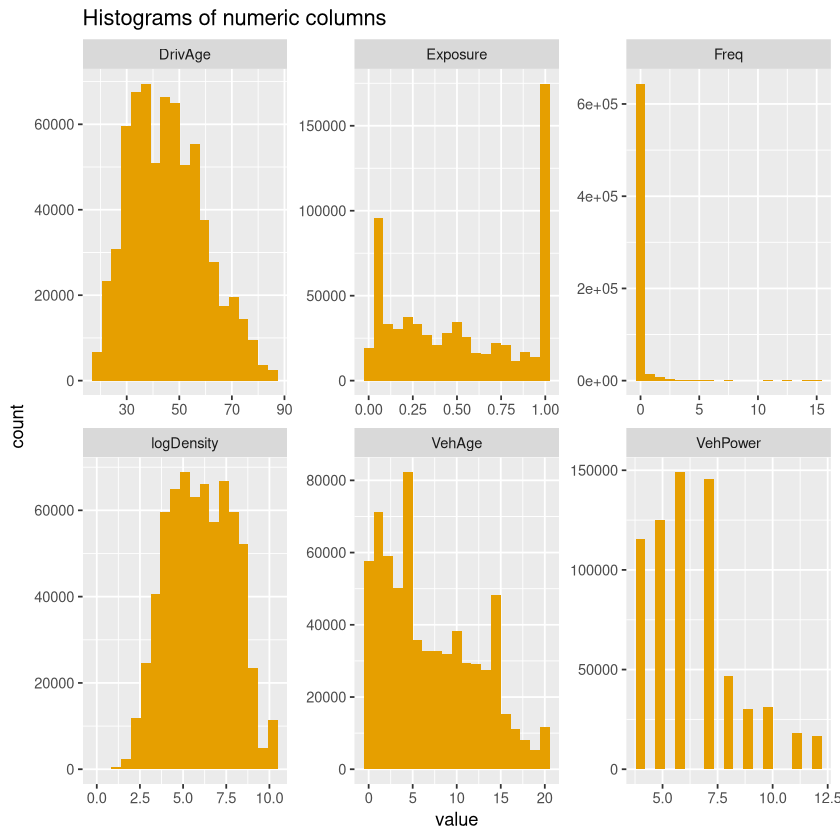

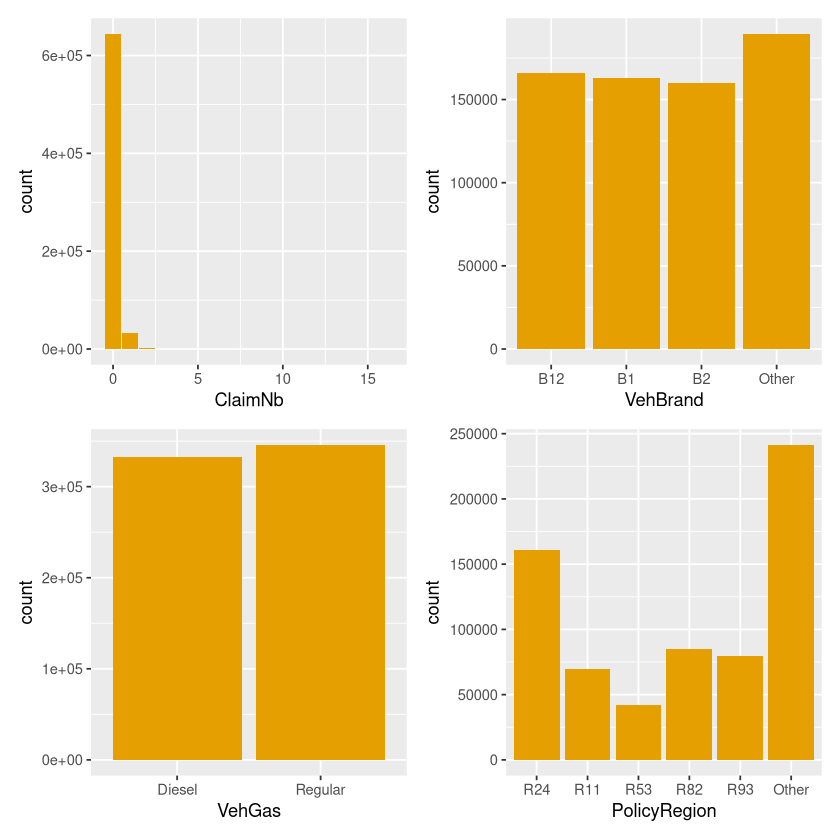

In [1]:
library(tidyverse)
library(patchwork)
library(OpenML)
library(farff)

main <- "french_motor"
# main <- "r/french_motor"
fillc <- "#E69F00"
refit <- TRUE # Set to FALSE after first run

if (refit) {
  # Download and save dataset
  raw_file <- file.path(main, "raw.rds")
  if (!file.exists(raw_file)) {
    raw <- tibble(getOMLDataSet(data.id = 41214)$data)
    saveRDS(raw, file = raw_file)
  } else {
    raw <- readRDS(raw_file)
  }

  # Preprocessing
  prep <- raw |>
    # Identify rows that might belong to the same policy
    group_by_at(
      c(
        "Area", "VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand",
        "VehGas", "Density", "Region"
      )
    ) |>
    mutate(group_id = cur_group_id(), group_size = n()) |>
    ungroup() |>
    arrange(group_id) |>
    # Usual preprocessing
    mutate(
      Exposure = pmin(1, Exposure),
      Freq = pmin(15, ClaimNb / Exposure),
      VehPower = pmin(12, VehPower),
      VehAge = pmin(20, VehAge),
      VehGas = factor(VehGas),
      DrivAge = pmin(85, DrivAge),
      logDensity = log(Density),
      VehBrand = relevel(fct_lump_n(VehBrand, n = 3), "B12"),
      PolicyRegion = relevel(fct_lump_n(Region, n = 5), "R24"),
      AreaCode = Area
    )

  # Covariates, response, weight
  x <- c(
    "VehPower", "VehAge", "VehBrand", "VehGas", "DrivAge",
    "logDensity", "PolicyRegion"
  )
  y <- "Freq"
  w <- "Exposure"
} else {
  load(file.path(main, "intro.RData"))
}

# Description
nrow(prep)
head(prep[, c("IDpol", "group_id", "ClaimNb", x, w, y)], 8)
summary(prep[, c(x, w, y)])

# Histograms
prep |>
  select(Freq, Exposure, DrivAge, VehAge, VehPower, logDensity) |>
  pivot_longer(everything()) |>
  ggplot(aes(x = value)) +
  geom_histogram(bins = 19, fill = fillc) +
  facet_wrap(~name, scales = "free") +
  ggtitle("Histograms of numeric columns")

# Barplots
x_discrete <- c("ClaimNb", "VehBrand", "VehGas", "PolicyRegion")
one_barplot <- function(v) {
  ggplot(prep, aes_string(v)) +
    geom_bar(fill = fillc)
}
wrap_plots(lapply(x_discrete, one_barplot), top = "Barplots of discrete columns")


**Comments:**

-   The dataset has about 680k observations.
-   The univariate distributions of the variables in the prepared dataset look plausible.
-   Rows 3 and 4 share the same "group_id", as do rows 6, 7, and 8. Not only are all of their risk factors identical, but their "IDpol" are very similar as well. This increases confidence in our proxy "group_id".

## The models

We will now calculate three models with R:

1.  An additive Poisson GLM fitted with the function `glm()` from the {stats} package, a
2.  Poisson GAM with several penalized regression smooths with the `gam()` function of the {mgcv} package, and a
3.  Poisson boosted trees model with implicit log link fitted by LightGBM [@ke2017] and tuned with grouped five-fold cross-validation.

The models are calculated on about 80% of the observations, while the rest is kept for model validation. Since we suspect that some policies are represented by multiple rows, the data split is done in a grouped way, assigning all rows with the same "group_id" to either the training or the test dataset. That logic was also applied to create the cross-validation folds for selecting or *tuning* the hyperparameters of the LightGBM model. More about grouped splits will follow in Chapter 2.

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.

Loading required package: R6


Attaching package: ‘lightgbm’


The following object is masked from ‘package:dplyr’:

    slice





Call:
glm(formula = reformulate(x, y), family = quasipoisson(), data = train, 
    weights = train[[w]])

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -2.114e+00  4.809e-02 -43.958  < 2e-16 ***
VehPower           4.878e-03  3.751e-03   1.300  0.19346    
VehAge            -3.441e-02  1.601e-03 -21.489  < 2e-16 ***
VehBrandB1        -1.602e-01  2.360e-02  -6.789 1.13e-11 ***
VehBrandB2        -1.606e-01  2.362e-02  -6.799 1.05e-11 ***
VehBrandOther     -1.473e-01  2.205e-02  -6.680 2.39e-11 ***
VehGasRegular      6.664e-02  1.484e-02   4.490 7.13e-06 ***
DrivAge           -5.104e-03  5.126e-04  -9.957  < 2e-16 ***
logDensity         6.453e-02  4.571e-03  14.116  < 2e-16 ***
PolicyRegionR11   -8.731e-02  3.169e-02  -2.755  0.00587 ** 
PolicyRegionR53   -1.392e-02  2.984e-02  -0.466  0.64092    
PolicyRegionR82    2.408e-05  2.546e-02   0.001  0.99925    
PolicyRegionR93   -8.260e-02  2.810e-02  -2.939  0.00329 ** 
PolicyRegionOther -1.191e


Family: quasipoisson 
Link function: log 

Formula:
Freq ~ s(VehAge, k = 7) + s(DrivAge, k = 7) + s(logDensity, k = 3) + 
    s(VehPower, k = 3) + PolicyRegion + VehBrand + VehGas

Parametric coefficients:
                   Estimate Std. Error  t value Pr(>|t|)    
(Intercept)       -2.215899   0.021029 -105.375  < 2e-16 ***
PolicyRegionR11   -0.072075   0.025752   -2.799 0.005130 ** 
PolicyRegionR53    0.006295   0.024221    0.260 0.794925    
PolicyRegionR82    0.021686   0.020673    1.049 0.294171    
PolicyRegionR93   -0.075672   0.022832   -3.314 0.000919 ***
PolicyRegionOther -0.106962   0.016496   -6.484 8.93e-11 ***
VehBrandB1        -0.128784   0.019845   -6.490 8.62e-11 ***
VehBrandB2        -0.140972   0.019829   -7.110 1.17e-12 ***
VehBrandOther     -0.106126   0.018589   -5.709 1.14e-08 ***
VehGasRegular      0.057907   0.012243    4.730 2.25e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
            

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.284446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 542170, number of used features: 7
[LightGBM] [Info] Start training from score -2.321650


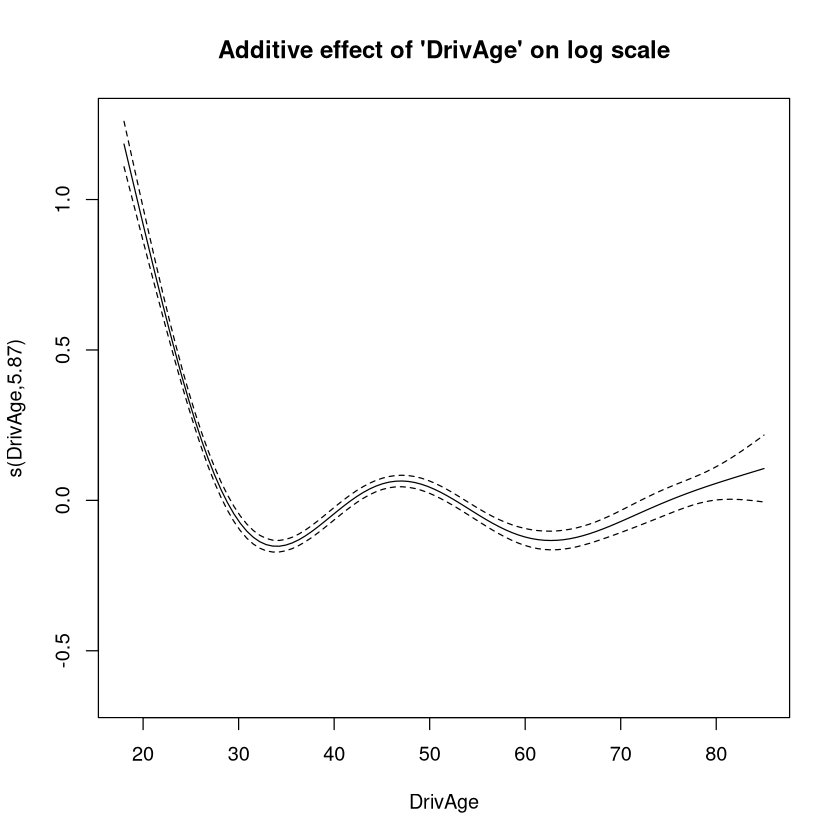

In [2]:
library(splitTools)
library(mgcv)
library(lightgbm)

set.seed(22) # Seeds the data split as well as the boosted trees model

ind <- partition(prep$group_id, p = c(train = 0.8, test = 0.2), type = "grouped")
train <- prep[ind$train, ]
test <- prep[ind$test, ]

# 1) GLM
if (refit) {
  fit_glm <- glm(
    reformulate(x, y),
    data = train, family = quasipoisson(), weights = train[[w]]
  )
}
summary(fit_glm)

# 2) GAM with penalized regression smooths and maximum k-1 df. Takes long to fit
if (refit) {
  fit_gam <- gam(
    Freq ~ s(VehAge, k = 7) + s(DrivAge, k = 7) + s(logDensity, k = 3) +
      s(VehPower, k = 3) + PolicyRegion + VehBrand + VehGas,
    data = train,
    family = quasipoisson(),
    weights = train[[w]]
  )
}
summary(fit_gam)

# Visualizing the effect of an additive component on the scale of the linear predictor
plot(fit_gam, select = 2, main = "Additive effect of 'DrivAge' on log scale")

# 3) Boosted trees
if (refit) {
  # Data interface of LightGBM (LGM)
  dtrain <- lgb.Dataset(
    data.matrix(train[x]),
    label = train[[y]],
    weight = train[[w]],
    params = list(feature_pre_filter = FALSE)
  )

  # Parameters found by CV randomized search, see later
  params <- list(
    learning_rate = 0.05,
    objective = "poisson",
    metric = "poisson",
    num_leaves = 63,
    min_data_in_leaf = 100,
    min_sum_hessian_in_leaf = 0,
    colsample_bynode = 0.8,
    bagging_fraction = 0.8,
    lambda_l1 = 4,
    lambda_l2 = 0,
    num_threads = 7 # adapt
  )

  # Fit model ("nrounds" is an optimized parameter as well, see later)
  fit_lgb <- lgb.train(params = params, data = dtrain, nrounds = 174)
  lgb.save(fit_lgb, file.path(main, "fit_lgb.txt"))
} else {
  fit_lgb <- lgb.load(file.path(main, "fit_lgb.txt"))
}

# Save everything important
if (refit) {
  save(x, y, w, fit_glm, fit_gam, prep, train, test, fillc,
    file = file.path(main, "intro.RData")
  )
}


**Comments:**

-   Fitting a GAM on 540k rows of data takes comparably long.
-   The code required to fit the boosted trees model is much longer than for the GLM and the GAM. However, the code is very general, so that only minor adaptions need to be made for other modeling situations.
-   Interpreting the GLM and the GAM can be easily made from the model output. For example, for the GLM, a one-point increase in "DrivAge" is associated with a change in log expected claims frequency of $-0.0051$. On the frequency scale, this corresponds to a change of $100\% \cdot (e^{-0.0051} - 1) \approx -0.5\%$. The GAM shows a more complex (and realistic) age effect. For the GLM and the GAM, the test statistics give us an indication of the variable importance: Vehicle age and driver age appear to be among the strongest predictors. What about the boosted trees model? It will be one of the goals of the next chapter to fill this gap using the tools of XAI.

# Exercises

Here, we will work with an Australian car claims dataset "dataCar" available in the R package {insuranceData}.

In [ ]:
library(tidyverse)
library(insuranceData)

data(dataCar)
head(dataCar)

# Data preparation
prep <- dataCar |>
  mutate(
    Freq = numclaims / exposure,
    Sev = claimcst0 / numclaims,
    veh_age = factor(veh_age),
    agecat = factor(agecat),
    veh_body = fct_lump_prop(veh_body, 0.1),
    log_value = log(pmax(0.3, pmin(15, veh_value)))
  )

# Variable groups
y_var <- "Freq"
w_var <- "exposure"
x_vars <- c("log_value", "agecat", "veh_age", "area", "veh_body", "gender")

# XGBoost parameters for the last exercise
params <- list(
  learning_rate = 0.05,
  objective = "count:poisson",
  max_depth = 2,
  colsample_bynode = 0.8,
  subsample = 0.8,
  reg_alpha = 1,
  reg_lambda = 0,
  min_split_loss = 0.001
)


1.  Descriptive Analysis
    i.  Study the data description via `?dataCar`.
    ii. Calculate relevant statistics at portfolio level, i.e., on the full dataset: Total and average exposure, total claim amount, number of claims, pure premium, frequency, and severity.
    iii. Describe the distribution of each model feature in `x_var` in the prepared dataset. Use tables and/or plots and/or text.
2.  Modeling: Next, we develop different claims frequency models using the same set of features (`x_vars`).
    i.  Split the dataset into 80% for training and 20% for testing. Don't touch the test data during modeling.
    ii. GLM: Fit an exposure-weighted Poisson GLM with log link to the claim frequencies. Interpret the estimated coefficients of the features "log_value" and "gender".
    iii. Random forest: Model "Freq" by an exposure-weighted random forest with the R package {ranger} using the quadratic loss. Select the optimal tree depth by minimizing exposure-weighted Poisson deviance calculated from the out-of-bag (OOB) predictions on the training data. How are OOB predictions being calculated? You can use the function `deviance_poisson()` in the {MetricsWeighted} package to calculate deviance.
    iv. XGBoost: Study the documentation of [XGBoost](https://xgboost.readthedocs.io/en/stable/). The original publication is @chen2016, and a fantastic slide deck (pdf) of the author can be found on this [Link](https://web.njit.edu/~usman/courses/cs675_fall16/BoostedTree.pdf). Use the {xgboost} package to fit an exposure-weighted Poisson XGBoost model with 196 boosting rounds and the hyperparameters stated in the code above. We will later see *how* to find such parameters. Note that XGBoost automatically uses a log link when fitting a Poisson model.

# References